## <font color=DarkTurquoise>Overall Goals</font>

<font color=Gray>The existence of the Transformers movie franchise raises a curious question: how can films that critics pan become massive box office successes, while critically acclaimed gems sometimes struggle commercially? This project explores the divide between critical and financial success in cinema, aiming to uncover what drives these differences. We’ll examine correlations between IMDb ratings and box office revenue to reveal general trends and identify outliers. Using a range of methodologies, from time-based and genre-specific analyses to sentiment analysis on plot summary, we aim to uncover patterns across genres, timeframes, and film attributes. Our approach integrates dataset merging, inflation-adjusted revenue comparisons, outlier classification, distribution analysis, and advanced sentiment modeling to answer our research questions and provide insight into this complex relationship between critics and audiences.</font>

## <font color=DarkTurquoise>Load Packages</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import json
import holoviews as hv
from holoviews import opts
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde
import ast
from src.script.plots import *
#from src.script.plots import *
from snownlp import SnowNLP
from snownlp import sentiment
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.utils import to_time_series_dataset
from scipy.interpolate import interp1d
from collections import Counter

## <font color=DarkTurquoise>Load Datasets</font>

<font color=Gray>The `data/cleaned_data.csv` dataset contains data from two sources, described as follows:</font>

### <font color=Gray>Dataset1: CMU Dataset</font>

<font color=Gray>We load and preprocess two datasets related to `movies` and `characters`, making adjustments to ensure consistency and readability in the movie DataFrame. The main adjustments are as follows:

(1) We capitalized the first letter of each movie name, making all names follow title case with the first letter capitalized and the rest in lowercase.This step facilitates merging dataset1 and dataset2 by standardizing the movie names.

(2) We replaced any occurrences of the accented characters é and è with e.

(3) We created a column that has the year of the movie release so that we can remove duplicates that have the same name but different release year.

(4) We removed movies with empty or null values in the box office revenue column.

(5) We extracted the movie genres and languages into separate lists for storage.


Data source:http://www.cs.cmu.edu/~ark/personas/</font>

### <font color=Gray>Dataset2: IMBD Dataset</font>

<font color=Gray>We have introduced two new datasets: The `title.ratings`, which contains movie ratings and the number of voters, adding two new dimensions to our data. The `title.basics` dataset provides a mapping between IDs and movie names, helping us integrate these new dimensions into the original dataset. The main adjustments are as follows:

(1) We excluded movies with fewer than 30 reviews, as these films have too few ratings to objectively assess their quality. However, this step is open to discussion.

(2) We capitalized the first letter of all entries in the `primaryTitle` column to use as the primary key for merging with the CMU dataset, and then remove any unnecessary columns.

Data source:https://datasets.imdbws.com/</font>

In [2]:
#Load data
cleaned_data = pd.read_csv('data/cleaned_data.csv')
cleaned_data['Movie genres'] = cleaned_data['Movie genres'].apply(ast.literal_eval)
cleaned_data['Movie countries'] = cleaned_data['Movie countries'].apply(ast.literal_eval)

### <font color=Gray>Dataset3: US-CPI Dataset</font>

<font color=Gray>We first plotted the curve showing the variation in average annual box office revenue over time. Although there are some fluctuations, we can observe an overall upward trend in the curve.</font>

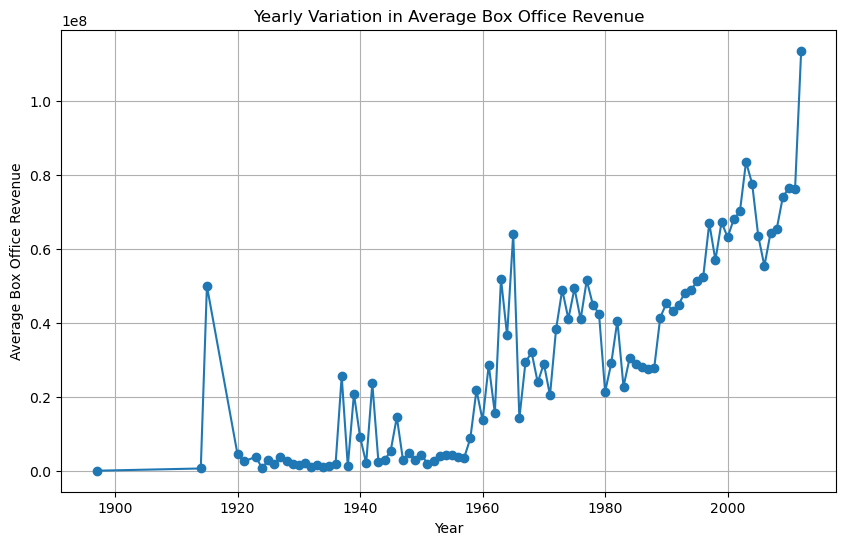

In [3]:
plot_by_year_nonadjusted(cleaned_data)

<font color=Gray>This phenomenon has several explanations. For instance, with the development of globalization, the number of cinemas has steadily increased worldwide. At the same time, advances in film production technology (such as 3D, IMAX) have enhanced the viewing experience. More theaters and improved viewing experiences attract a broader audience, driving box office revenue growth.

However, the primary factor we need to consider is that movie ticket prices have been rising each year due to `inflation`. This leads to an increase in total box office revenue, even if the number of moviegoers remains steady or slightly declines. Therefore, we need to adjust for inflation's effect on box office revenue and introduce the `US-CPI` index as a measure of inflation.</font>

In [4]:
# Load dataset
inflation = pd.read_csv('data/inflation.csv')

# Merge the inflation data with cleaned_data based on matching 'Year' and 'Movie release year' columns
cleaned_data = pd.merge(inflation, cleaned_data, left_on='Year', right_on='Movie release year', how='right').drop(columns=['CPI'])

# Calculate the adjusted revenue by multiplying 'Movie box office revenue' by the inflation 'rate'
cleaned_data['Adjusted_Revenue'] = cleaned_data['Movie box office revenue']*cleaned_data['rate']

<font color=Gray>We plotted a comparison of the average annual box office revenue before and after adjustment. It can be observed that the adjusted average annual revenue is higher than the original.</font>

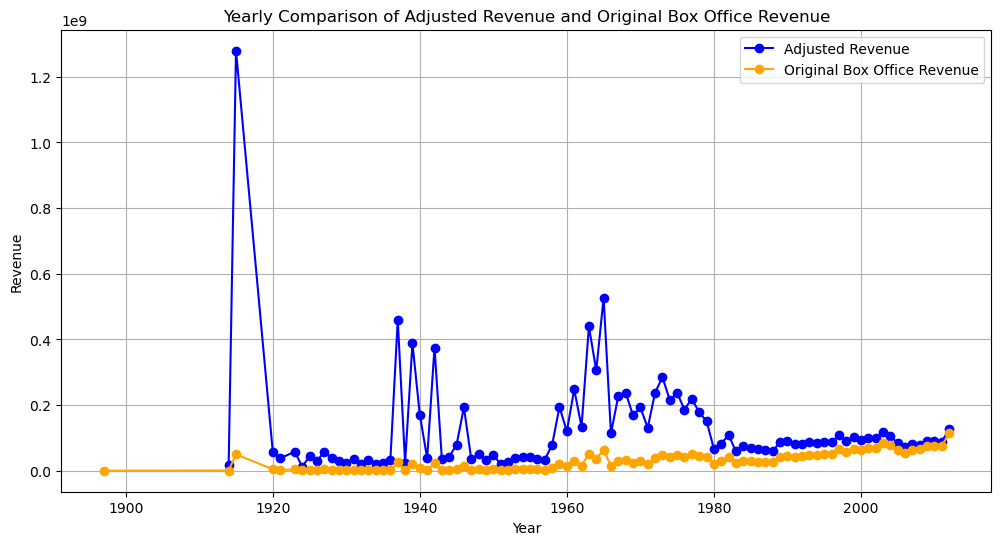

In [5]:
plot_by_year_comparison_outlier(cleaned_data, outlier_years=0)

## <font color=DarkTurquoise>Observe Distribution</font>

<font color=Gray>We first examine the joint distribution of the two main variables in our study: `box office revenue` and `ratings`. We can see that the distribution of box office revenue is right-skewed, mainly concentrated in the lower range. Therefore, we need to apply a logarithmic transformation to the box office revenue, which is beneficial for subsequent data processing.</font>

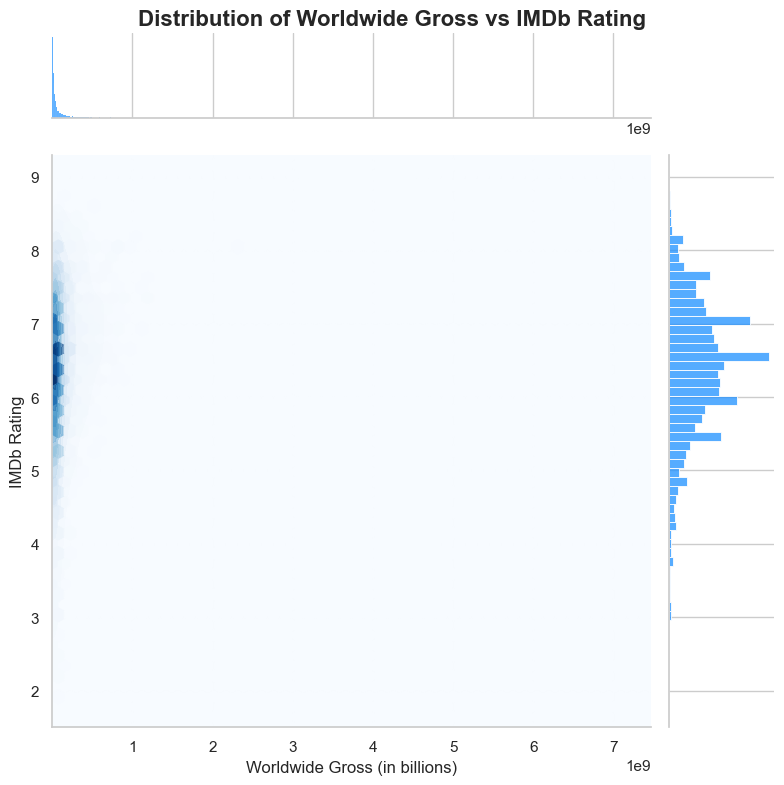

In [6]:
# Drop rows where 'Adjusted revenue' contains NaN values to avoid missing data in the plot
cleaned_data.drop(cleaned_data[cleaned_data['Adjusted_Revenue'].isnull()].index, inplace=True)
plot_distr_unadjusted(cleaned_data)

<font color=Gray>After applying a log transformation to the box office revenue, the new distribution appears more reasonable. We can also observe the range where ratings and box office revenue are concentrated.</font>

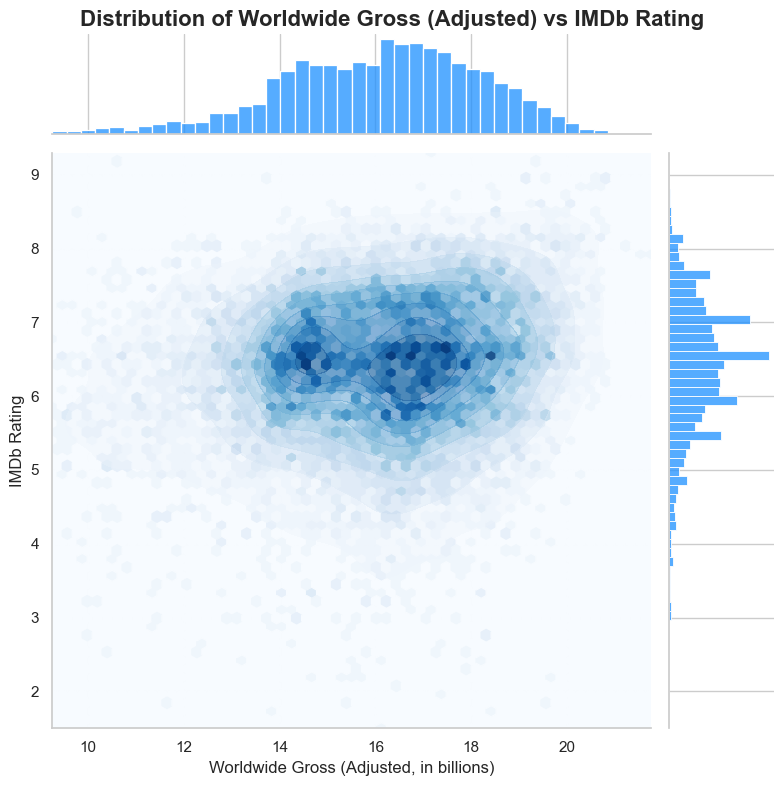

In [7]:
#Display the Adjusted World Gross vs. IMDb Rating plot with the same method when displaying Uadjusted World Gross vs. IMDb Rating plot
cleaned_data['Log_Revenue'] = np.log1p(cleaned_data['Movie box office revenue'])

# Drop rows where 'Log_Revenue' is null (e.g., missing or invalid box office data)
cleaned_data.drop(cleaned_data[cleaned_data['Log_Revenue'].isnull()].index, inplace=True)

plot_distr_adjusted(cleaned_data)

## <font color=DarkTurquoise>Linear Regression</font>

<font color=Gray>We perform a regression of `Log_Revenue` on `averageRating` to get a basic look at the linear relationship between the two. 

**Note:**
It should be noted that this regression likely suffers from omitted variable bias, as we need to consider more factors that could influence both box office revenue and ratings. However, since our dataset is still incomplete (currently being supplemented), this aspect will be addressed in Part 3.</font>

In [8]:
#Perform an Ordinary Least Squares (OLS) regression using the statsmodels library. 
model = smf.ols(formula='Log_Revenue ~ averageRating', data=cleaned_data).fit(cov_type='HC2')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Log_Revenue   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     164.4
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           3.13e-37
Time:                        16:05:48   Log-Likelihood:                -15992.
No. Observations:                7439   AIC:                         3.199e+04
Df Residuals:                    7437   BIC:                         3.200e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        13.9594      0.169     82.710

<font color=Gray>The regression coefficient for averageRating is **0.3349**, which suggests that for each one-unit increase in averageRating, the Log_Revenue is expected to increase by **0.3349**, holding other factors constant.

**t-Statistic (12.820) and p-Value (0.000):** The high t-statistic and p-value being effectively zero implies that the coefficient is significantly different from zero, reinforcing that averageRating has a statistically significant effect on Log_Revenue.</font>

## <font color=DarkTurquoise>Classification</font>

<font color=Gray>We categorize movies into three types: `those with matched box office and ratings`, `high box office with low ratings`, and `low box office with high ratings`. We are particularly interested in understanding the factors behind the latter two categories. 

The first issue to address is how to distinguish these three types. Our approach is to shift the regression line up and down by one standard deviation, dividing the plane into three regions. Points larger than one std with rating lower than 6.5 are considered `Overperformed`  (high box office with low ratings), those in the lower than one std with rating larger than 6.5 are `Underperformed` (low box office with high ratings), and points between the two lines fall into the **matched category**.</font>

In [9]:
predictions = model.predict()
std_dev = np.std(predictions - cleaned_data['Log_Revenue'])
# Calculate residuals by subtracting predictions from the actual Log_Revenue values
residuals = cleaned_data['Log_Revenue'] - predictions

# Identify outliers where the absolute value of residuals is greater than the standard deviation
outliers = cleaned_data[np.abs(residuals) > std_dev]['Log_Revenue']
print(outliers.count())  

# Separate data into two categories: higher and lower outliers
higher = cleaned_data[(residuals > std_dev) & (cleaned_data['averageRating'] < 6.5)].copy()

# 'lower' contains rows where residuals are less than negative one standard deviation (negative outliers)
lower = cleaned_data[(residuals < -std_dev) & (cleaned_data['averageRating'] > 6.5)].copy()


# Print the number of higher and lower outliers
print('length of higher:', len(higher), 'length of lower:', len(lower))


2370
length of higher: 593 length of lower: 502


In [10]:
higher.to_csv("data/higher.csv", index=False)
lower.to_csv("data/lower.csv", index=False)

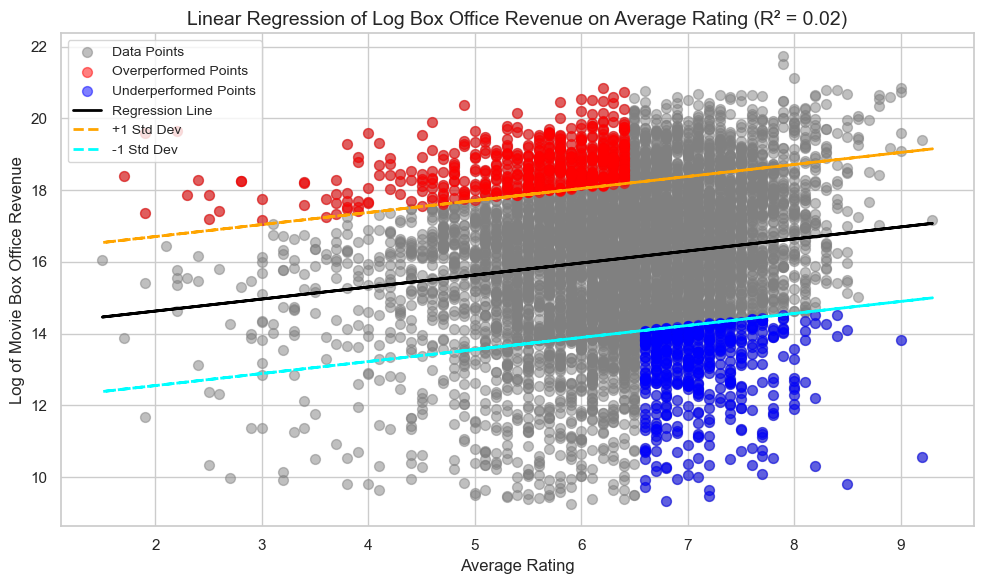

In [11]:
plot_correlation_general(cleaned_data, model, higher, lower)

Interactive version below (needs downloading; static plot should be enough from direct git viewing)

<font color=Gray>We aim to further examine the regression and classification for each country. The plots are shown below:

We can observe that:

(1) Most movies originate from the United States, France, South Korea, and the United Kingdom, while scatter plots for other countries are relatively sparse.

(2) In most countries, box office revenue tends to increase with higher ratings. The slope is particularly steep for the United States, the United Kingdom, Canada, Australia, and Hong Kong.</font>

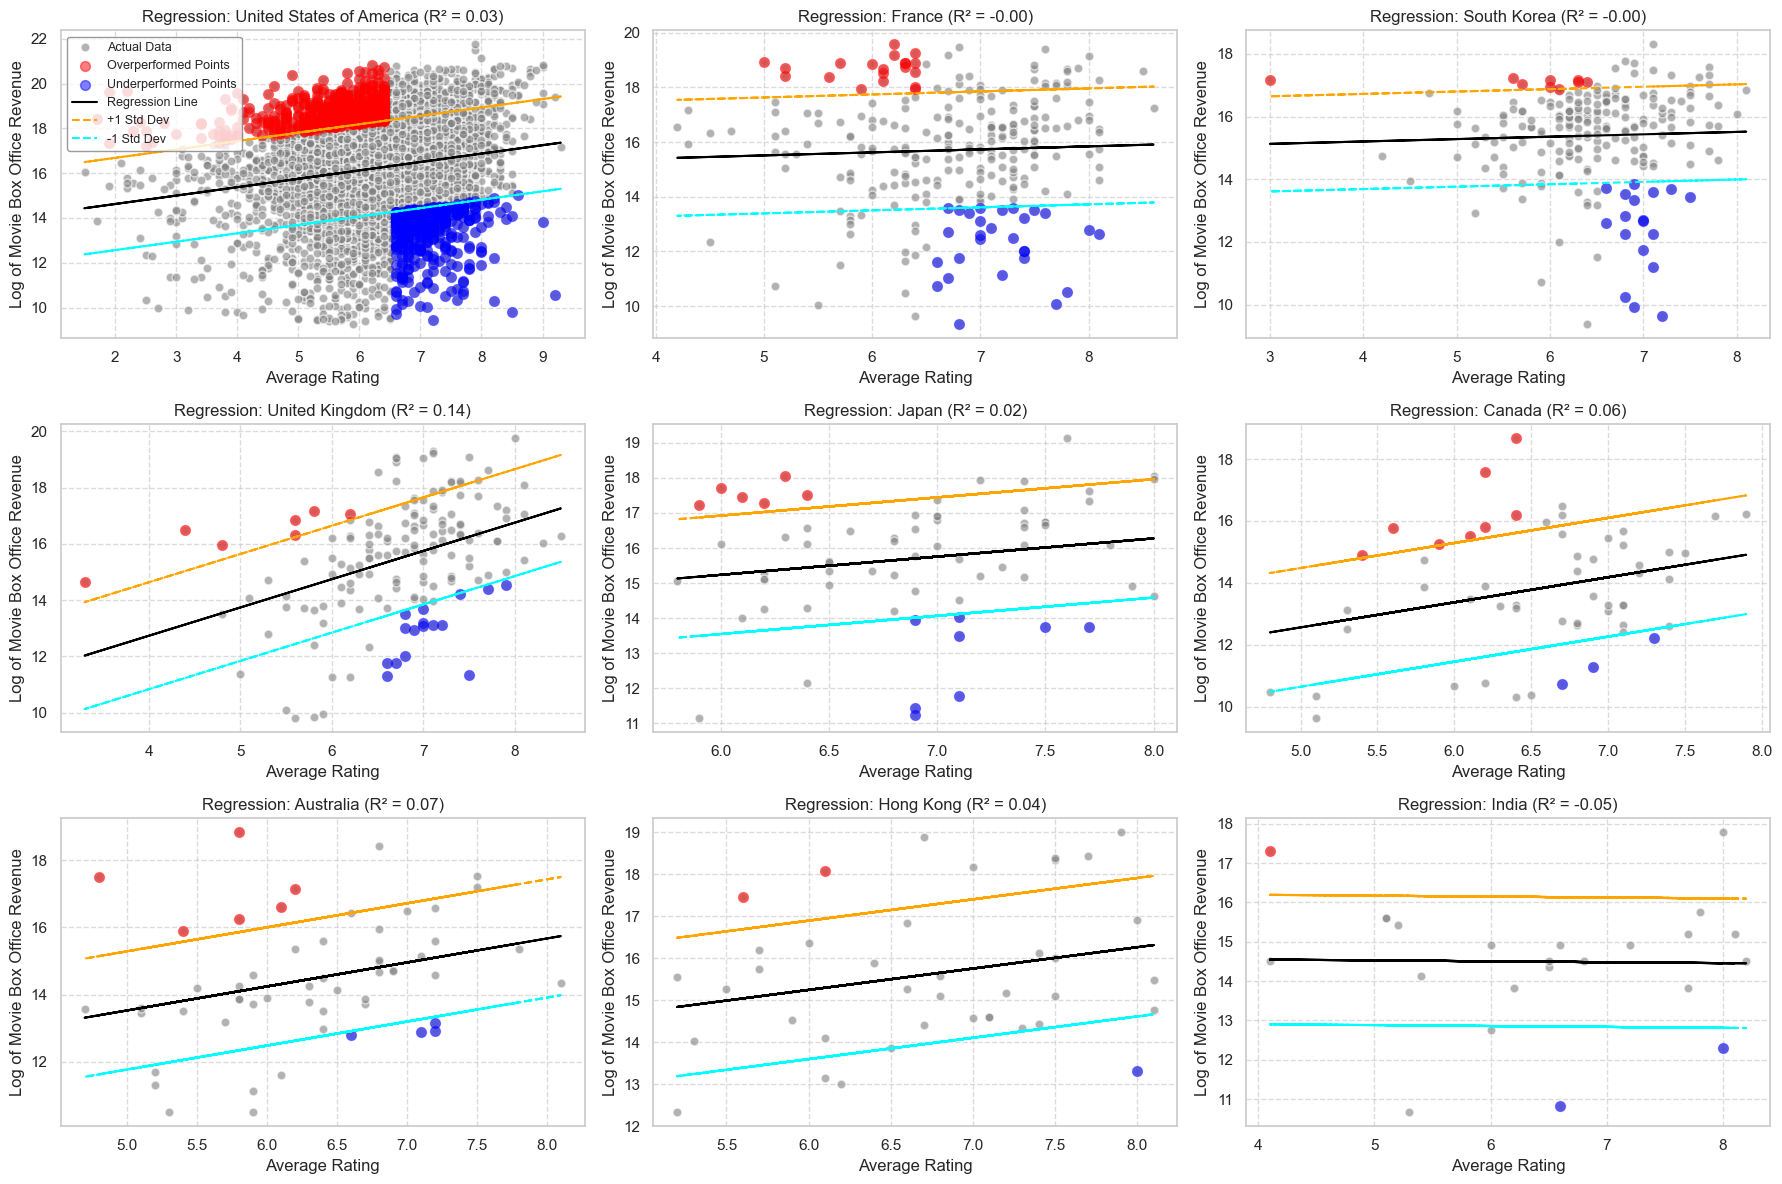

In [12]:
plot_correlation_per_country(cleaned_data)

<font color=Gray>We aim to further examine the regression and classification for ten time points (from 1915 to 2015). The plots are shown below:

We can observe that:

(1) From the overall trend, the number of movies has been increasing in recent years, which is reflected by the growing number of points in the scatter plots.

(2) The regression curves for nearly all years show an upward trend, indicating that box office revenue increases as ratings rise.
</font>

In [16]:
def plot_correlation_per_timeframe(cleaned_data, selected_years):
    """
    Plots the log revenue vs rating scatterplot of movie data per the selected timeframe specified, calculates R2 correlation score, while also plotting +1 standard deviation interval around the linear regression line
    :param cleaned_data: Processed dataframe
    :param selected_years: Selected timeframe in list or range() format
    :return: scatterplot
    """
    # Find the maximum year in the dataset for reference
    cleaned_data['Year'].max()

    # Subset the data to only include rows where the year is in the selected years
    subset = cleaned_data[cleaned_data['Year'].isin(selected_years)]

    # Generate a color palette for each year based on the number of selected years
    colors_years = plt.cm.tab10(np.linspace(0, 1, len(selected_years)))

    # Set up the figure size for the plot
    plt.figure(figsize=(15, 10))

    # Loop through each selected year and create a subplot for each
    for i, year in enumerate(selected_years, 1):
        plt.subplot(2, 5, i)  
        year_data = subset[subset['Year'] == year] 

        # Perform OLS regression for Log_Revenue based on averageRating for the current year
        model_years = smf.ols(formula='Log_Revenue ~ averageRating', data=year_data).fit(cov_type='HC2')
        coefficients_years = model_years.params  
        predictions_years = model_years.predict()  
        r2_score_years = model_years.rsquared_adj  

        # Calculate the standard deviation of residuals for the regression model
        std_dev_years = np.std(predictions_years - year_data['Log_Revenue'])

        # Plot actual data points with unique color for each year
        plt.scatter(year_data['averageRating'], year_data['Log_Revenue'], color='gray', alpha=0.6, s=40, edgecolor='white', label='Actual Data')
        condition = (predictions_years - year_data['Log_Revenue'] < - std_dev_years) & \
            (cleaned_data['averageRating'] < 6.5)
        # Reindex the condition to match country_data's index
        condition = condition.reindex(year_data.index, fill_value=False)

        higher = year_data.loc[condition].copy()
        plt.scatter(higher['averageRating'], higher['Log_Revenue'], 
                    color='red', alpha=0.5, s=50, label='Overperformed Points')
        condition = (predictions_years - year_data['Log_Revenue'] > std_dev_years) & \
            (cleaned_data['averageRating'] > 6.5)
        # Reindex the condition to match country_data's index
        condition = condition.reindex(year_data.index, fill_value=False)
        lower = year_data.loc[condition].copy()
        plt.scatter(lower['averageRating'], lower['Log_Revenue'], 
                    color='blue', alpha=0.5, s=50, label='Underperformed Points')
        plt.plot(year_data['averageRating'], predictions_years, color='black', label='Regression Line')
        # Plot lines for +1 and -1 standard deviations from the regression line
        plt.plot(year_data['averageRating'], predictions_years + std_dev_years, color='orange', linestyle='--', label='+1 Std Dev')
        plt.plot(year_data['averageRating'], predictions_years - std_dev_years, color='Cyan', linestyle='--', label='-1 Std Dev')

        # Set labels and title for the subplot
        plt.xlabel('Average Rating')
        plt.ylabel('Log of Movie Box Office Revenue')
        plt.title(f'Regression: {year} (R² = {r2_score_years:.2f})')

        # Add grid lines for better readability
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add legend only for the first subplot
        if i == 1:
            plt.legend(fontsize=9, loc='upper left', frameon=True, framealpha=0.8, edgecolor='gray')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the entire set of subplots
    plt.show()

e:\anaconda3\envs\ada\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
e:\anaconda3\envs\ada\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
e:\anaconda3\envs\ada\Lib\site-packages\statsmodels\regression\linear_model.py:2003: RuntimeWarning: divide by zero encountered in divide
  self.het_scale = self.wresid**2/(1-h)


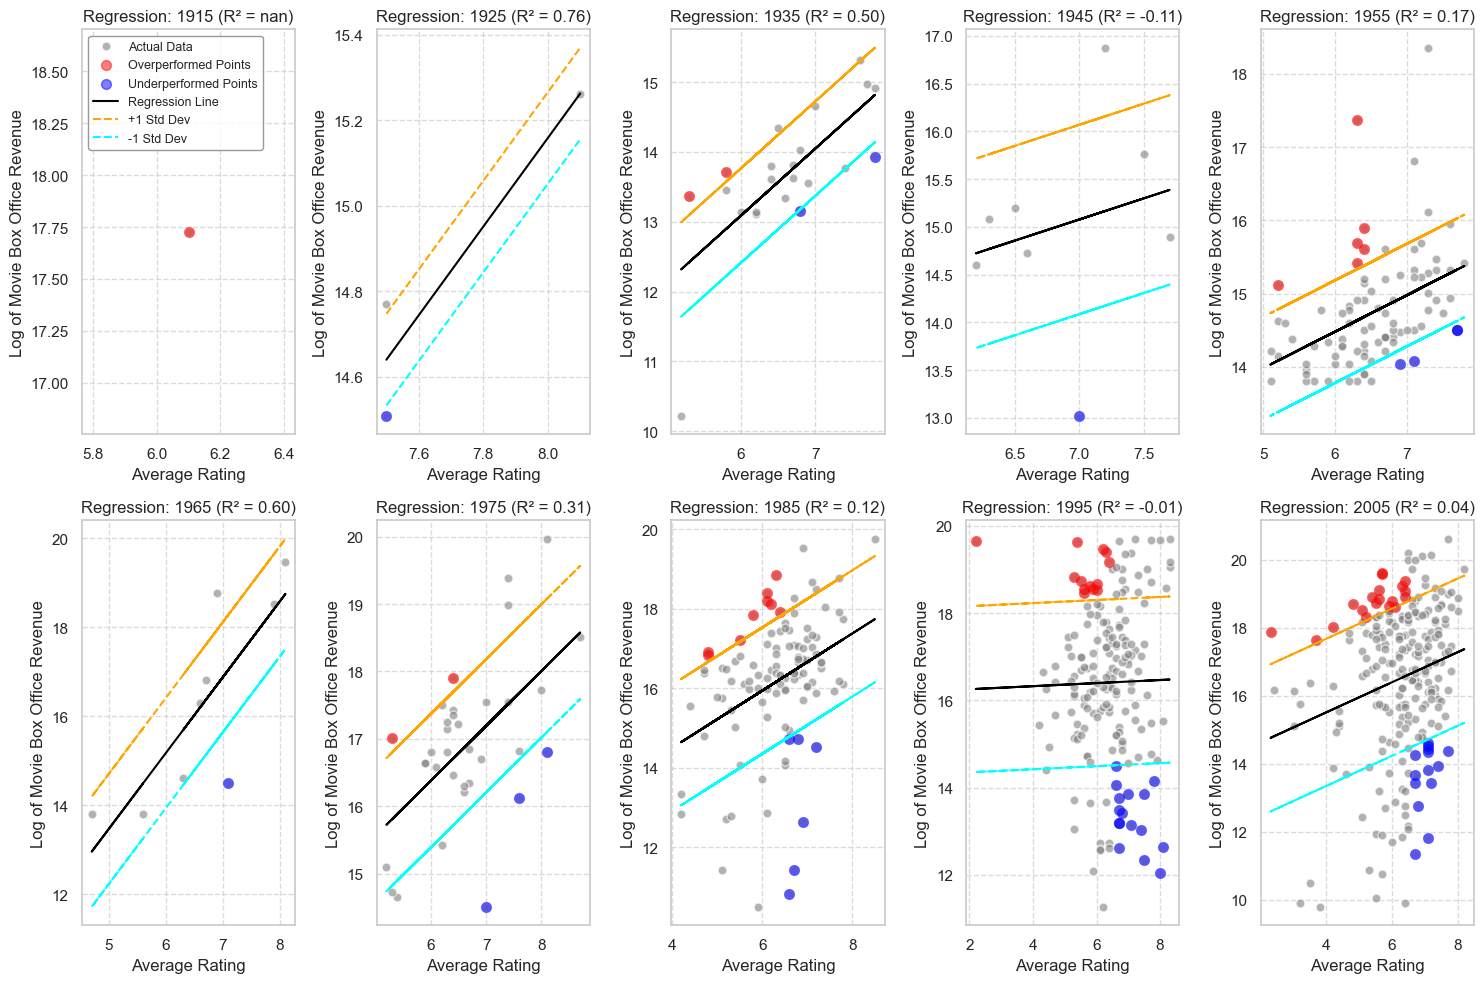

In [17]:
# Define the range of selected years, starting from 1915 and selecting every 10 years up to 2015
selected_years = range(1915, 2015, 10)
plot_correlation_per_timeframe(cleaned_data, selected_years)

## <font color=DarkTurquoise>Overperformed VS Underperformed</font>

#### <font color=DarkTurquoise>(1) Movie Genre</font>

<font color=Gray>We can see that the number of movies defined as `Overperformed` is **1231**, while the number of movies defined as `Underperformed` is **1139**.</font>

<font color=Gray>Next, we examine the genre distribution of these two categories of movies separately. In our dataset, each movie’s genre is represented as a list, with the first genre indicating the primary category. We will start by analyzing the number of movies in each genre, sorting them from highest to lowest. Then, we will assess the percentage of each genre when it appears as the `first genre`, `second genre`, and `third genre`. We adopt this approach because we recognize all three genre slots might be important and that overlapping might exist between different genre slots, thus we aim to capture genre information as comprehensively as possible.</font>

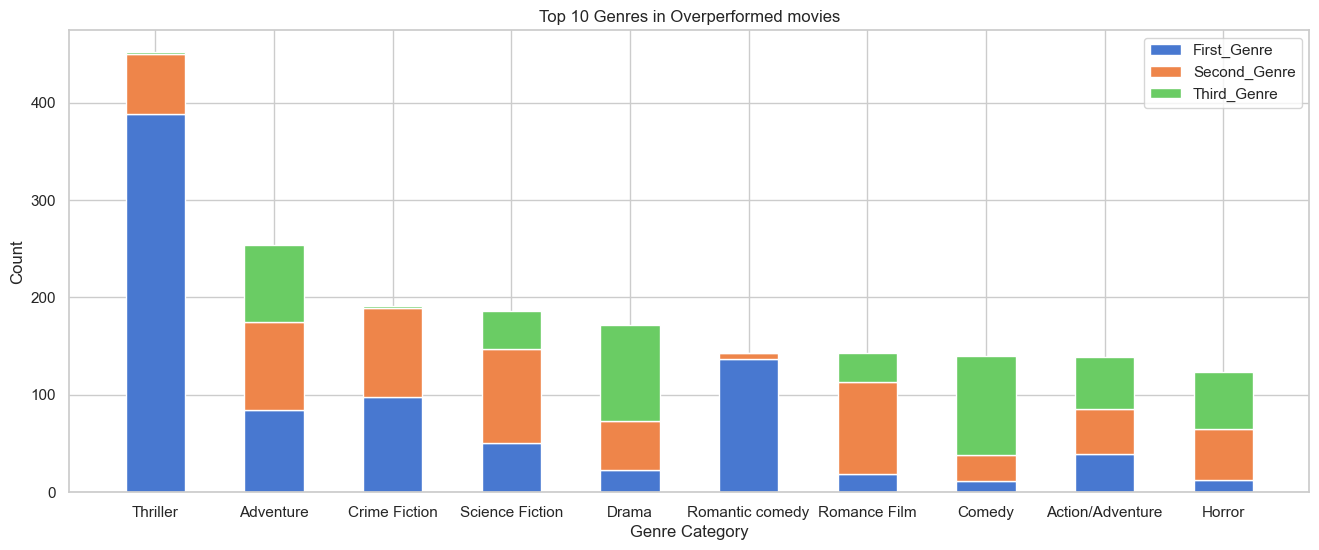

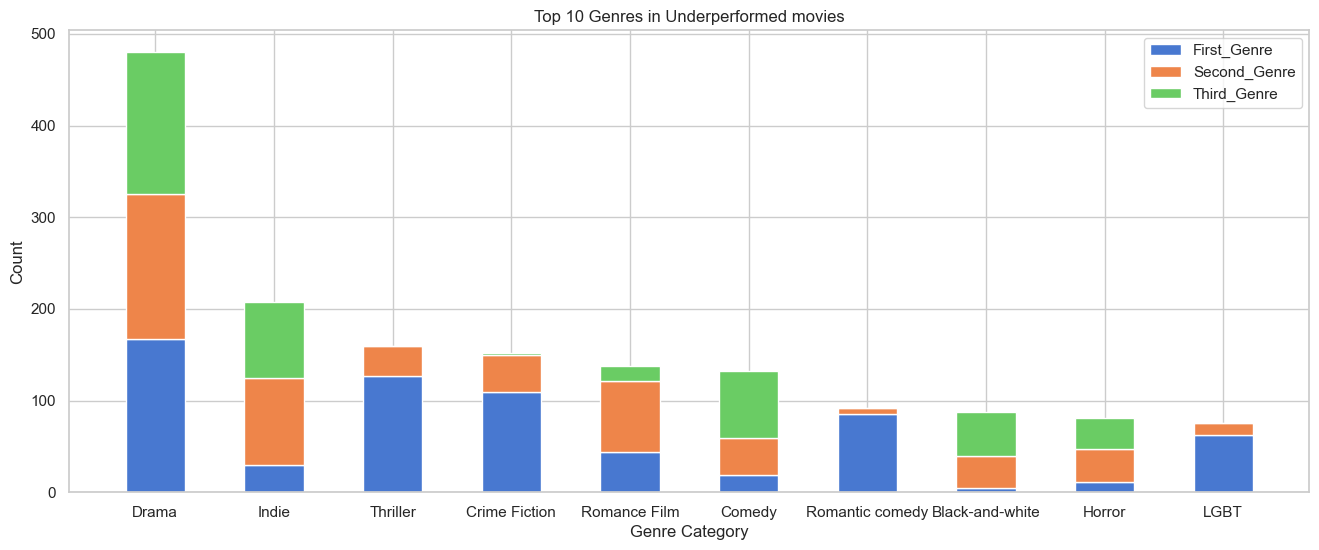

In [ ]:
plot_genre_distribution(cleaned_data, model)

Interpretion: The above bar charts allow us to see the distribution of genres listed as "first", "second", and "third" genres slots, as well as distribution of genres in general since the ordering might not be semantically significant in the first place. A promising finding is that the *Thriller* genre appears to outclass the other genres in numbers among overperforming movies, while the same appears to hold true for the *Drama* genre among underperforming ones. This potentially indicates audience taste, and the factors (actors, etc.) that might've contributed to, or potentially even confounded, these results can be subject to further analysis later in the project.

<font color=Gray>Please also find below the interactive version of the movie genre distribution chart (download might be needed; non-interactive version should be sufficient for direct viewing from git).</font>

#### <font color=DarkTurquoise>(2) Relationship between movie genre and actor's gender</font>

In [ ]:
character = pd.read_csv("data/character.metadata.tsv", delimiter='\t',header=None)
character.columns = ['Wikipedia movie ID','Freebase Movie ID','Actor DOD','Character Name','Actor DOB','Actor gender','Actor height','Actor ethnicity','Actor Name','Actor age at movie release','Freebase character map1','Freebase character map2','Freebase character map3']
merged_data = pd.merge(cleaned_data, character, on='Wikipedia movie ID', how='inner')
merged_data.head(5)

Year      rate  averageRating  Wikipedia movie ID Freebase movie ID  \
0  2001.0  1.459642            4.9              975900         /m/03vyhn   
1  2001.0  1.459642            4.9              975900         /m/03vyhn   
2  2001.0  1.459642            4.9              975900         /m/03vyhn   
3  2001.0  1.459642            4.9              975900         /m/03vyhn   
4  2001.0  1.459642            4.9              975900         /m/03vyhn   

       Movie name  Movie box office revenue  Movie runtime  \
0  Ghosts of mars                14010832.0           98.0   
1  Ghosts of mars                14010832.0           98.0   
2  Ghosts of mars                14010832.0           98.0   
3  Ghosts of mars                14010832.0           98.0   
4  Ghosts of mars                14010832.0           98.0   

                      Movie languages             Movie countries  ...  \
0  {"/m/02h40lc": "English Language"}  [United States of America]  ...   
1  {"/m/02h40lc": "English Language"}  [United States of America]  ...   
2  {"/m/02h40lc": "English Language"}  [United States of America]  ...   
3  {"/m/02h40lc": "English Language"}  [United States of America]  ...   
4  {"/m/02h40lc": "English Language"}  [United States of America]  ...   

               Character Name   Actor DOB  Actor gender Actor height  \
0                    Akooshay  1958-08-26             F        1.620   
1  Lieutenant Melanie Ballard  1974-08-15             F        1.780   
2         Desolation Williams  1969-06-15             M        1.727   
3          Sgt Jericho Butler  1967-09-12             M        1.750   
4             Bashira Kincaid  1977-09-25             F        1.650   

   Actor ethnicity          Actor Name Actor age at movie release  \
0              NaN      Wanda De Jesus                       42.0   
1       /m/044038p  Natasha Henstridge                       27.0   
2          /m/0x67            Ice Cube                       32.0   
3              NaN       Jason Statham                       33.0   
4              NaN         Clea DuVall                       23.0   

  Freebase character map1 Freebase character map2 Freebase character map3  
0              /m/0bgchxw              /m/0bgcj3x              /m/03wcfv7  
1               /m/0jys3m              /m/0bgchn4               /m/0346l4  
2               /m/0jys3g              /m/0bgchn_              /m/01vw26l  
3              /m/02vchl6              /m/0bgchnq               /m/034hyc  
4              /m/02vbb3r              /m/0bgchp9               /m/01y9xg  

[5 rows x 28 columns]

In [ ]:
higher = pd.read_csv("data/higher.csv" )
lower = pd.read_csv("data/lower.csv" )

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
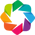

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18952\3381826946.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['First_genre'] = merged_data['Movie genres'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18952\3381826946.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Actor gender'] = merged_data['Actor gender']


:Chord   [source,target]   (weight)

In [ ]:
import holoviews as hv
from holoviews import opts
import matplotlib.pyplot as plt
hv.extension('bokeh')

higher_ids = set(higher['Wikipedia movie ID'])  
df = merged_data[merged_data['Wikipedia movie ID'].isin(higher_ids)]

df['First_genre'] = merged_data['Movie genres'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
df['Actor gender'] = merged_data['Actor gender']

grouped = df.groupby(['First_genre', 'Actor gender']).size().reset_index(name='Count')

links = grouped.apply(lambda x: (x['First_genre'], x['Actor gender'], x['Count']), axis=1).tolist()

unique_genres = df['First_genre'].dropna().unique()
unique_genders = df['Actor gender'].dropna().unique()
nodes = list(unique_genres) + list(unique_genders)

color_palette = plt.get_cmap('Set3')  
genre_colors = {genre: color_palette(i % color_palette.N) for i, genre in enumerate(unique_genres)}
gender_colors = {gender: ('#87CEEB' if gender == 'M' else '#FFC0CB') for gender in unique_genders}
color_map = {**genre_colors, **gender_colors}

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % tuple(int(255 * x) for x in rgb[:3])

color_map = {key: rgb_to_hex(value) if isinstance(value, tuple) else value for key, value in color_map.items()}

nodes_df = pd.DataFrame({'index': nodes, 'color': [color_map[n] for n in nodes]})

links_df = pd.DataFrame(links, columns=['source', 'target', 'weight'])

chord = hv.Chord((links_df, hv.Dataset(nodes_df, 'index')))

chord = chord.opts(
    edge_color='red',                   
    edge_alpha=0.5,                       
    edge_line_width=0.5,                   
    labels='index',                      
    node_color='color',                  
    node_size=10,                         
    title="First Genre and Actor Gender Chord Diagram (Overperformed)",
    height=600,                          
    width=600                              
)

chord


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
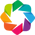

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18952\4276374343.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['First_genre'] = merged_data['Movie genres'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18952\4276374343.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Actor gender'] = merged_data['Actor gender']


:Chord   [source,target]   (weight)

In [ ]:
import holoviews as hv
from holoviews import opts
import matplotlib.pyplot as plt
hv.extension('bokeh')

lower_ids = set(lower['Wikipedia movie ID'])  
df = merged_data[merged_data['Wikipedia movie ID'].isin(lower_ids)]

df['First_genre'] = merged_data['Movie genres'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
df['Actor gender'] = merged_data['Actor gender']

grouped = df.groupby(['First_genre', 'Actor gender']).size().reset_index(name='Count')

links = grouped.apply(lambda x: (x['First_genre'], x['Actor gender'], x['Count']), axis=1).tolist()

unique_genres = df['First_genre'].dropna().unique()
unique_genders = df['Actor gender'].dropna().unique()
nodes = list(unique_genres) + list(unique_genders)

color_palette = plt.get_cmap('Set3')  
genre_colors = {genre: color_palette(i % color_palette.N) for i, genre in enumerate(unique_genres)}
gender_colors = {gender: ('#87CEEB' if gender == 'M' else '#FFC0CB') for gender in unique_genders}
color_map = {**genre_colors, **gender_colors}  

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % tuple(int(255 * x) for x in rgb[:3])

color_map = {key: rgb_to_hex(value) if isinstance(value, tuple) else value for key, value in color_map.items()}

nodes_df = pd.DataFrame({'index': nodes, 'color': [color_map[n] for n in nodes]})

links_df = pd.DataFrame(links, columns=['source', 'target', 'weight'])

chord = hv.Chord((links_df, hv.Dataset(nodes_df, 'index')))

chord = chord.opts(
    edge_color='blue',                     
    edge_alpha=0.5,                         
    edge_line_width=0.5,                   
    labels='index',                       
    node_color='color',                     
    node_size=10,                          
    title="First Genre and Actor Gender Chord Diagram (Underperformed)",
    height=600,                           
    width=600                              
)

chord


#### <font color=DarkTurquoise>(3) Sentiment classification</font>

{'neutral': 0, 'sadness': 1, 'enthusiasm': 2, 'worry': 3, 'surprise': 4, 'love': 5, 'fun': 6, 'hate': 7, 'happiness': 8, 'boredom': 9, 'relief': 10, 'anger': 11}

In [ ]:
higher_labels = pd.read_csv("data/higher_labels.csv" )
lower_labels = pd.read_csv("data/lower_labels.csv" )
combined_df = pd.concat([higher_labels, lower_labels], axis=0, ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
label_mapping = {
    0: 'neutral', 1: 'sadness', 2: 'enthusiasm', 3: 'worry', 4: 'surprise', 
    5: 'love', 6: 'fun', 7: 'hate', 8: 'happiness', 9: 'boredom', 
    10: 'relief', 11: 'anger'
}

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18952\1630707706.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Extracted Labels"] = df["Predicted Label"].apply(extract_numbers)


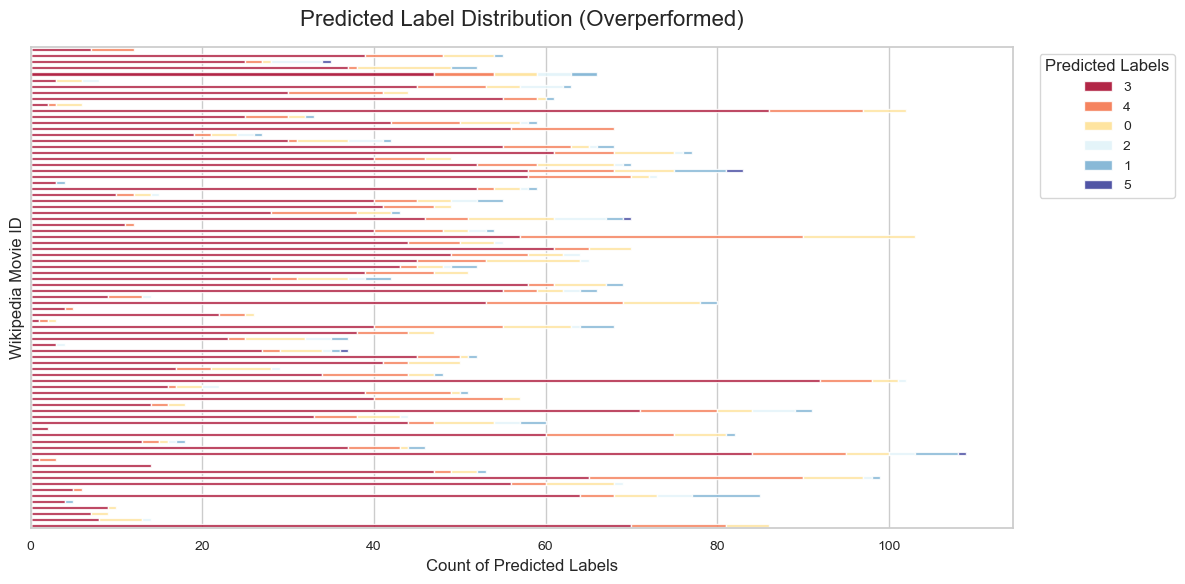

In [ ]:
df = combined_df.head(80)

def extract_numbers(labels):
    numbers = re.findall(r'\d+', labels)  
    return list(map(int, numbers)) 

df["Extracted Labels"] = df["Predicted Label"].apply(extract_numbers)

label_distribution = df["Extracted Labels"].apply(lambda x: pd.Series(x).value_counts()).fillna(0)
label_distribution.index = df["Wikipedia movie ID"]

ax = label_distribution.plot(
    kind="barh", 
    stacked=True,
    figsize=(12, 6),
    alpha=0.85,
    cmap="RdYlBu"  
)

ax.set_title("Predicted Label Distribution (Overperformed)", fontsize=16, pad=15)
ax.set_xlabel("Count of Predicted Labels", fontsize=12)
ax.set_yticks([]) 
ax.set_ylabel("Wikipedia Movie ID", fontsize=12)
plt.xticks(fontsize=10)

plt.legend(
    title="Predicted Labels",
    bbox_to_anchor=(1.02, 1), loc="upper left",
    fontsize=10,
    title_fontsize=12,
    frameon=True
)

plt.tight_layout()

plt.show()

In [ ]:
import re
def most_frequent(labels):
    if labels:  # Ensure the list is not empty
        numbers = re.findall(r'\d+', labels)  # 提取所有数字，返回列表 ['3', '3', '3', '3', '0', '4']
        numbers = list(map(int, numbers)) 
        return Counter(numbers).most_common(1)[0][0]  # Get the most frequent element
    return None  # Return None if the list is empty

def second_most_frequent(labels):
    if labels:  # Ensure the list is not empty
        numbers = re.findall(r'\d+', labels)  # 提取所有数字，返回列表 ['3', '3', '3', '3', '0', '4']
        numbers = list(map(int, numbers))  # 转换为整数
        counts = Counter(numbers).most_common()  # 获取所有数字及其出现频率的排序列表
        if len(counts) > 1:  # 确保至少有两个不同元素
            return counts[1][0]  # 返回第二常出现的值
        elif counts:  # 如果只有一个元素
            return counts[0][0]  # 返回唯一的元素
    return None  # 如果列表为空，返回 None

# 计算每行的众数并生成新的一列
higher_labels["Most Frequent Label"] = higher_labels["Predicted Label"].apply(most_frequent)
higher_labels["Second Most Frequent Label"] = higher_labels["Predicted Label"].apply(second_most_frequent)
lower_labels["Most Frequent Label"] = lower_labels["Predicted Label"].apply(most_frequent)
lower_labels["Second Most Frequent Label"] = lower_labels["Predicted Label"].apply(second_most_frequent)
lower_labels["Second Most Frequent Label"].value_counts()

Second Most Frequent Label
4    407
0    321
3     90
2     60
1     53
5      1
Name: count, dtype: int64

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18952\3288172112.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Accent', len(label_counts))


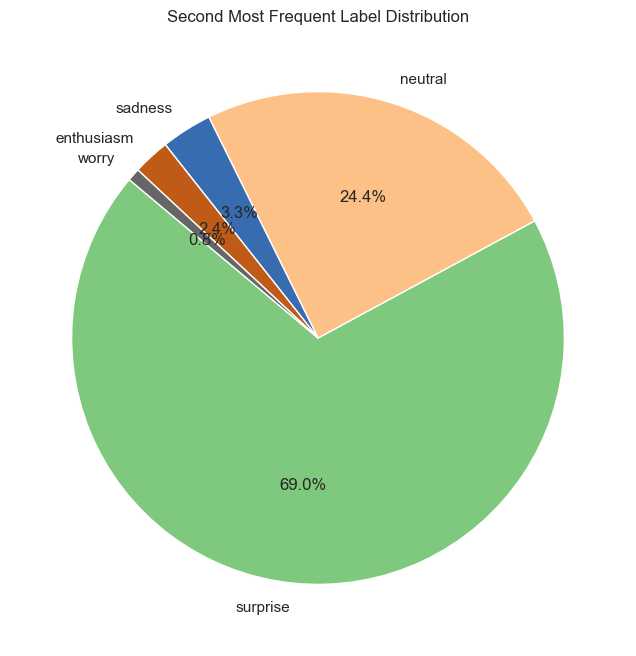

In [ ]:
import matplotlib.cm as cm
higher_labels['Second Most Frequent Label'] = higher_labels['Second Most Frequent Label'].replace(label_mapping)
label_counts = higher_labels["Second Most Frequent Label"].value_counts()
cmap = cm.get_cmap('Accent', len(label_counts)) 
color_list = [cmap(i) for i in range(len(label_counts))]
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=color_list)
plt.title("Second Most Frequent Label Distribution")
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18952\1579800172.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Accent', len(label_counts))


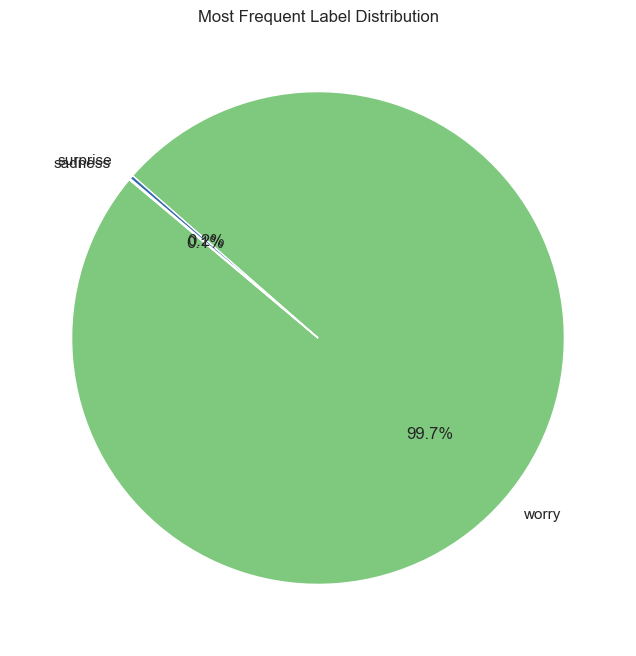

In [ ]:
import matplotlib.cm as cm
higher_labels['Most Frequent Label'] = higher_labels['Most Frequent Label'].replace(label_mapping)
label_counts = higher_labels["Most Frequent Label"].value_counts()
cmap = cm.get_cmap('Accent', len(label_counts)) 
color_list = [cmap(i) for i in range(len(label_counts))]
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=color_list)
plt.title("Most Frequent Label Distribution")
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18952\4189665698.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Accent', len(label_counts))


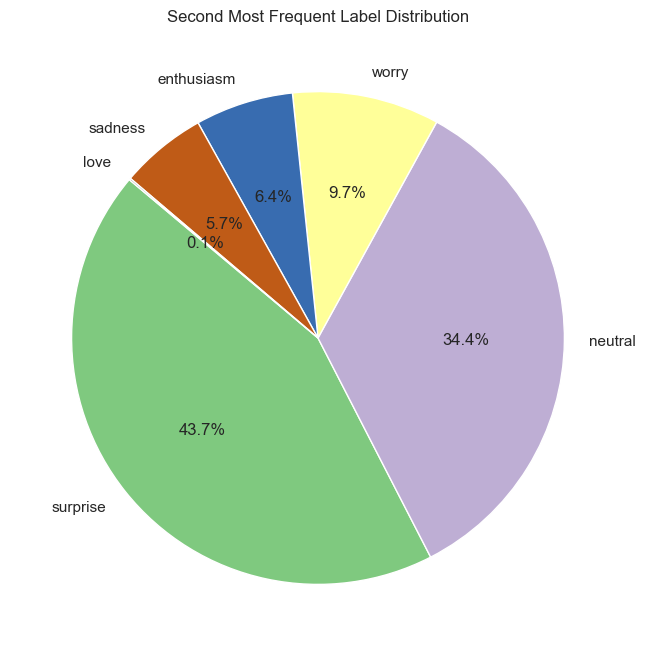

In [ ]:
import matplotlib.cm as cm
lower_labels['Second Most Frequent Label'] = lower_labels['Second Most Frequent Label'].replace(label_mapping)
label_counts = lower_labels["Second Most Frequent Label"].value_counts()
cmap = cm.get_cmap('Accent', len(label_counts)) 
color_list = [cmap(i) for i in range(len(label_counts))]
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=color_list)
plt.title("Second Most Frequent Label Distribution")
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18952\501741428.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Accent', len(label_counts))


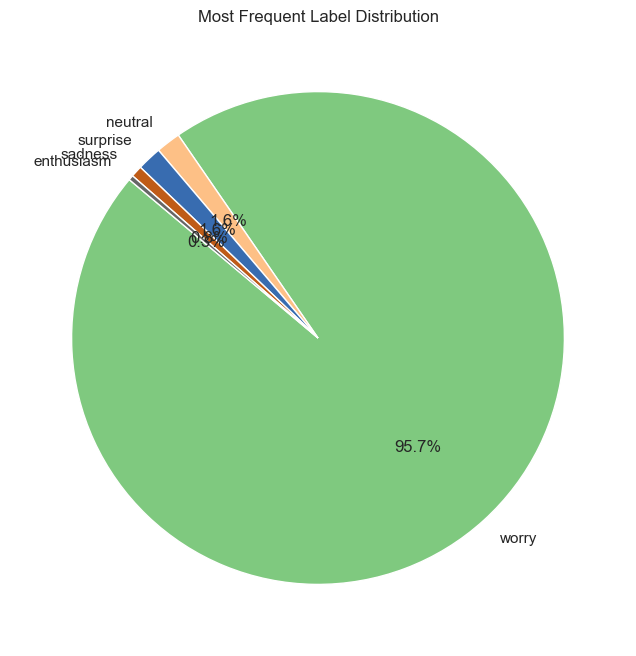

In [ ]:
import matplotlib.cm as cm
lower_labels['Most Frequent Label'] = lower_labels['Most Frequent Label'].replace(label_mapping)
label_counts = lower_labels["Most Frequent Label"].value_counts()
cmap = cm.get_cmap('Accent', len(label_counts)) 
color_list = [cmap(i) for i in range(len(label_counts))]
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=color_list)
plt.title("Most Frequent Label Distribution")
plt.show()

#### <font color=DarkTurquoise>(4) Sentiment curve</font>

In [ ]:
file_path = "data/sentiment_value.csv"  
sentiment_value = pd.read_csv(file_path)
h_senvalue = sentiment_value[sentiment_value["Wikipedia movie ID"].isin(higher["Wikipedia movie ID"])]
l_senvalue = sentiment_value[sentiment_value["Wikipedia movie ID"].isin(lower["Wikipedia movie ID"])]
sentiment = pd.concat([h_senvalue, l_senvalue], ignore_index=True)
sentiment= sentiment.dropna(how="all")
sentiment_value = sentiment.fillna(0)

In [ ]:
def standardize_score(senvalue):
    df = senvalue  # Example DataFrame
    time_series_data = df.drop(columns=["Wikipedia movie ID"])

    avg_len = int(np.mean([len(row.dropna()) for _, row in time_series_data.iterrows()]))

    interpolated_series = []
    for _, row in time_series_data.iterrows():
        row = row.dropna().values  # Remove NaN values from the current row
        x_original = np.linspace(0, 1, len(row))  # Original time points
        x_new = np.linspace(0, 1, avg_len)  # New time points based on average length
        interpolator = interp1d(x_original, row, kind='linear', fill_value="extrapolate")
        interpolated_series.append(interpolator(x_new))  # Interpolate the series to the new length

    # Format the interpolated series into the required format for tslearn
    formatted_series = to_time_series_dataset(interpolated_series)
    return formatted_series[:,:,0]

In [ ]:
# Perform K-means clustering on the time series
n = 3
h_formatted_series = standardize_score(sentiment_value)
model = TimeSeriesKMeans(n_clusters=n, metric="dtw", random_state=0)
labels = model.fit_predict(h_formatted_series)
print("Cluster labels:", labels)

KeyboardInterrupt: 

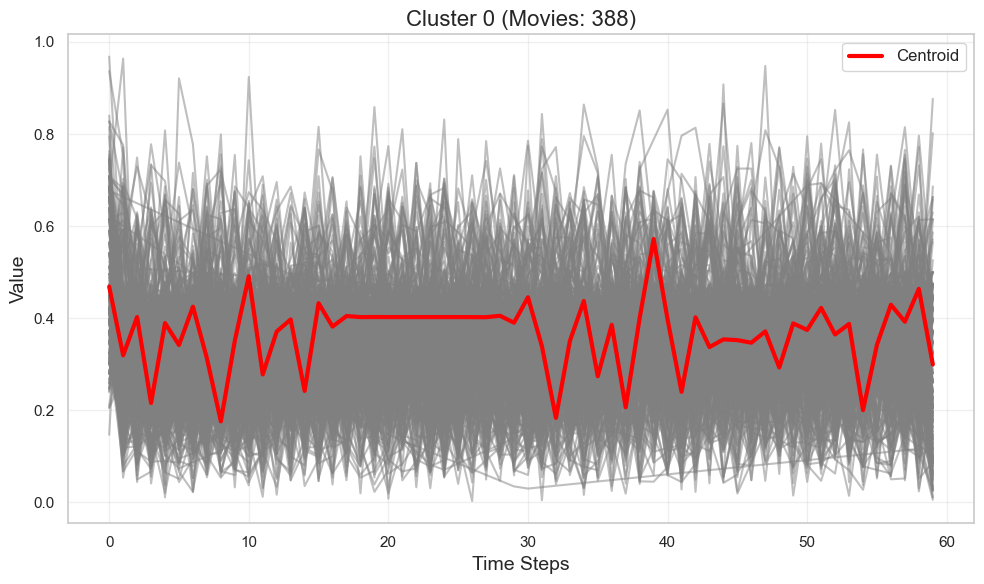

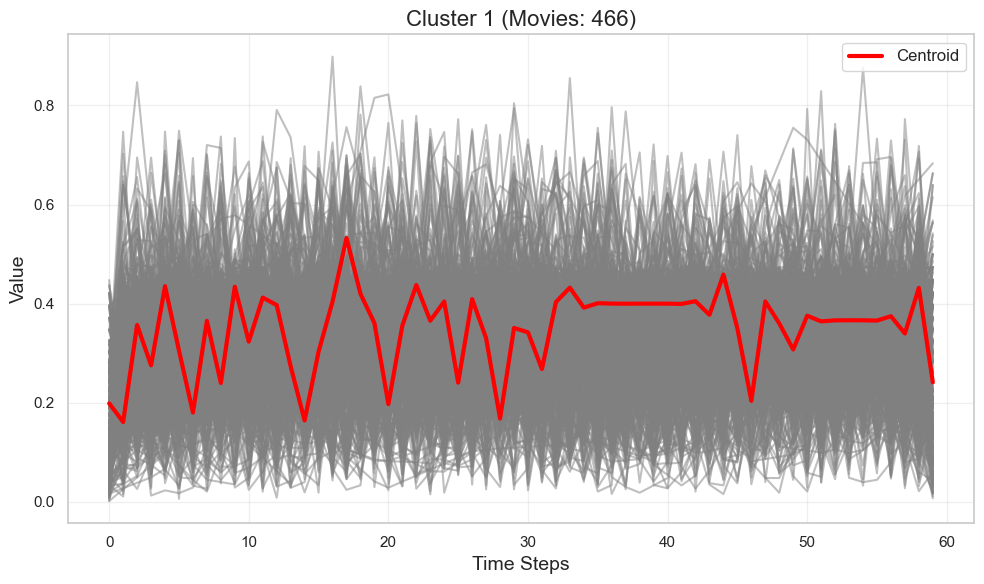

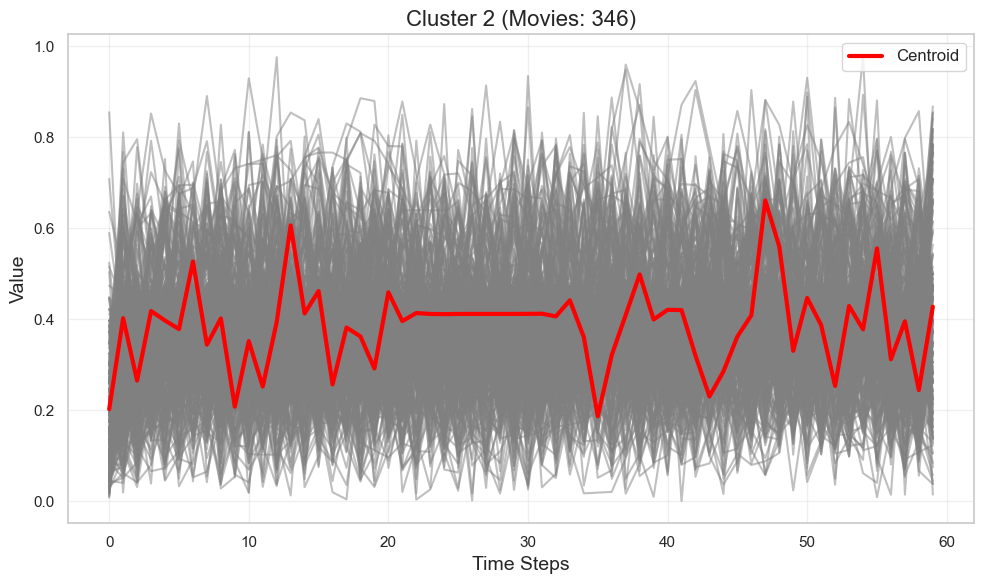

In [ ]:
label_counts = Counter(labels)

for cluster in range(n):
    plt.figure(figsize=(10, 6))  

    for i, label in enumerate(labels):
        if label == cluster:
            plt.plot(h_formatted_series[i].ravel(), color='gray', alpha=0.5)  # 无标签灰色曲线

    plt.plot(
        model.cluster_centers_[cluster].ravel(),
        color='red',
        linewidth=3,
        #linestyle='--',
        label="Centroid"
    )

    num_movies = label_counts[cluster]
    
    plt.title(f"Cluster {cluster} (Movies: {num_movies})", fontsize=16)
    plt.xlabel("Time Steps", fontsize=14)
    plt.ylabel("Value", fontsize=14)
    plt.grid(alpha=0.3) 
    plt.legend(loc="upper right", fontsize=12)
    plt.tight_layout()
    plt.show()

# <font color=DarkTurquoise>Osillation Analysis</font>


In [ ]:
def standardize_score(senvalue):
    df = senvalue  # Example DataFrame
    time_series_data = df.drop(columns=["Wikipedia movie ID"])

    avg_len = int(np.mean([len(row.dropna()) for _, row in time_series_data.iterrows()]))

    interpolated_series = []
    for _, row in time_series_data.iterrows():
        row = row.dropna().values  # Remove NaN values from the current row
        x_original = np.linspace(0, 1, len(row))  # Original time points
        x_new = np.linspace(0, 1, avg_len)  # New time points based on average length
        interpolator = interp1d(x_original, row, kind='linear', fill_value="extrapolate")
        interpolated_series.append(interpolator(x_new))  # Interpolate the series to the new length

    # Format the interpolated series into the required format for tslearn
    formatted_series = to_time_series_dataset(interpolated_series)
    return formatted_series[:,:,0]
file_path = "data/sentiment_value.csv"  
sentiment_value = pd.read_csv(file_path)
higher = pd.read_csv('data/higher.csv')
lower = pd.read_csv('data/lower.csv')
h_senvalue = sentiment_value[sentiment_value["Wikipedia movie ID"].isin(higher["Wikipedia movie ID"])]
l_senvalue = sentiment_value[sentiment_value["Wikipedia movie ID"].isin(lower["Wikipedia movie ID"])]

In [ ]:
import numpy as np
from scipy.signal import find_peaks

def count_emotional_fluctuations(emotion_curve, threshold=0.0):
    """
    Counts the number of emotional fluctuations (alternating peaks and valleys) in an emotion curve.
    :param emotion_curve: The emotion curve (1D array)
    :param threshold: Fluctuation threshold (used to filter out insignificant fluctuations)
    :return: Number of fluctuations
    """
    peaks, _ = find_peaks(emotion_curve)  # Find peaks in the emotion curve
    valleys, _ = find_peaks(-emotion_curve)  # Find valleys by detecting peaks in the inverted curve
    extrema = np.sort(np.concatenate((peaks, valleys)))  # Combine and sort peaks and valleys
    fluctuation_count = 0
    for i in range(1, len(extrema)):
        # Check if the difference between consecutive extrema exceeds the threshold
        if abs(emotion_curve[extrema[i]] - emotion_curve[extrema[i - 1]]) > threshold:
            fluctuation_count += 1
    return fluctuation_count


c:\Anaconda3\envs\ada\Lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


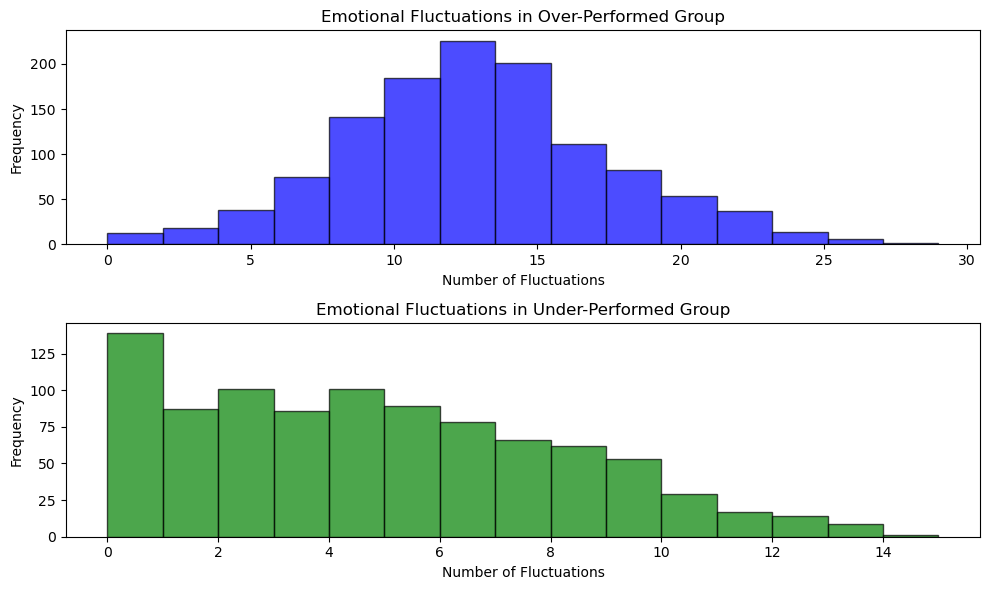

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Standardize the scores for the "high-sensitivity" and "low-sensitivity" groups
# Standardize scores for high-sensitivity group
h_standard_score = standardize_score(h_senvalue)  

# Standardize scores for low-sensitivity group
l_standard_score = standardize_score(l_senvalue)  

# Step 2: Set the threshold for detecting significant emotional fluctuations
amplitude_threshold = 0.2  # Define a threshold for significant fluctuations

# Step 3: Calculate the number of emotional fluctuations for each curve
# For high-sensitivity group
h_fluctuations = [
    count_emotional_fluctuations(curve, amplitude_threshold) 
    for curve in h_standard_score
]

# For low-sensitivity group
l_fluctuations = [
    count_emotional_fluctuations(curve, amplitude_threshold) 
    for curve in l_standard_score
]

# Step 4: Plot histograms for the emotional fluctuations
plt.figure(figsize=(10, 6))  # Set the overall figure size

# Plot the histogram for the high-sensitivity group's emotional fluctuations
plt.subplot(2, 1, 1)  # Create a subplot in the top panel
plt.hist(h_fluctuations, bins=15, color='blue', alpha=0.7, edgecolor='black')  # Enhanced visual properties
plt.title("Emotional Fluctuations in Over-Performed Group")  # Add a title
plt.xlabel("Number of Fluctuations")  # Label the x-axis
plt.ylabel("Frequency")  # Label the y-axis

# Plot the histogram for the low-sensitivity group's emotional fluctuations
plt.subplot(2, 1, 2)  # Create a subplot in the bottom panel
plt.hist(l_fluctuations, bins=15, color='green', alpha=0.7, edgecolor='black')  # Enhanced visual properties
plt.title("Emotional Fluctuations in Under-Performed Group")  # Add a title
plt.xlabel("Number of Fluctuations")  # Label the x-axis
plt.ylabel("Frequency")  # Label the y-axis

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Display the histograms
plt.show()

In [ ]:
def count_emotion_magnitude(emotion_curve, threshold=0.0):
    """
    Calculates the magnitude of emotional fluctuations in an emotion curve.
    The magnitude is defined as the difference between the maximum and minimum values in the curve.

    :param emotion_curve: The emotion curve (1D array or list of values).
    :param threshold: Threshold (not used in the current implementation, but kept for potential extensions).
    :return: The magnitude of fluctuations (float).
    """
    magnitude = np.max(emotion_curve) - np.min(emotion_curve)  # Compute the range of values (max - min)
    return magnitude  # Return the magnitude


c:\Anaconda3\envs\ada\Lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


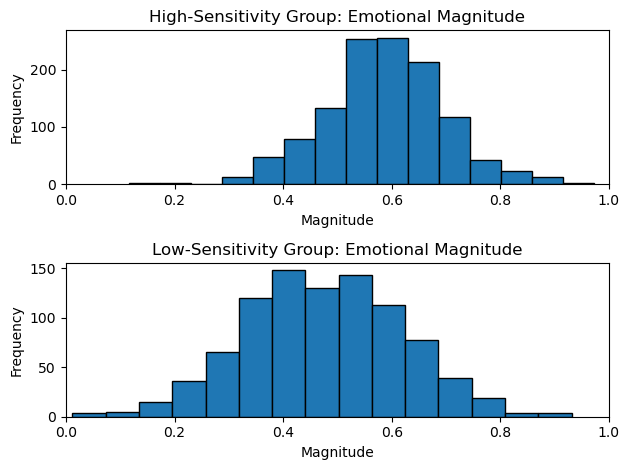

In [ ]:
# Standardize the scores for the "high-sensitivity" and "low-sensitivity" groups
h_standard_score = standardize_score(h_senvalue)  # Standardize scores for high-sensitivity group
l_standard_score = standardize_score(l_senvalue)  # Standardize scores for low-sensitivity group

# Set the amplitude threshold for filtering emotional magnitudes
amplitude_threshold = 0.2

# Calculate the magnitude of emotional fluctuations for each curve in the high-sensitivity group
h_fluctuations = [count_emotion_magnitude(curve, amplitude_threshold) for curve in h_standard_score]

# Calculate the magnitude of emotional fluctuations for each curve in the low-sensitivity group
l_fluctuations = [count_emotion_magnitude(curve, amplitude_threshold) for curve in l_standard_score]

# Plot the histogram for the high-sensitivity group's emotional fluctuation magnitudes
plt.subplot(2, 1, 1)  # Create a subplot (top panel)
plt.hist(h_fluctuations, bins=15, edgecolor='black')  # Add edgecolor for better visibility
plt.xlim(0, 1)  # Set the x-axis limits for consistency
plt.title("High-Sensitivity Group: Emotional Magnitude")  # Add a title
plt.xlabel("Magnitude")  # Label the x-axis
plt.ylabel("Frequency")  # Label the y-axis

# Plot the histogram for the low-sensitivity group's emotional fluctuation magnitudes
plt.subplot(2, 1, 2)  # Create a subplot (bottom panel)
plt.hist(l_fluctuations, bins=15, edgecolor='black')  # Add edgecolor for better visibility
plt.xlim(0, 1)  # Set the x-axis limits for consistency
plt.title("Low-Sensitivity Group: Emotional Magnitude")  # Add a title
plt.xlabel("Magnitude")  # Label the x-axis
plt.ylabel("Frequency")  # Label the y-axis

# Adjust layout for better visualization
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def linear_regression_on_sequences(standard):
    """
    Performs linear regression on a set of sequences and filters results based on the p-value of the slope.
    
    :param standard: List or array of sequences (each sequence is a list or 1D array).
    :return: DataFrame containing the regression results for sequences with significant slopes.
    """
    results = []
    for idx, sequence in enumerate(standard):
        # Convert the sequence to a NumPy array
        y = np.array(sequence)  # Dependent variable (y)
        x = np.arange(len(y))   # Independent variable (x), a sequence of integers from 0 to len(y)-1
        
        # Add a constant term (intercept) to the independent variable
        x = sm.add_constant(x)
        
        # Fit the ordinary least squares (OLS) regression model
        model = sm.OLS(y, x).fit()
        
        # Extract regression coefficients and p-values
        coefficients = model.params  # Regression coefficients [intercept, slope]
        p_values = model.pvalues     # p-values for the coefficients [intercept, slope]
        
        # Check if the p-value for the slope is below the significance threshold (0.1)
        if p_values[1] < 0.1:  # Consider slope significant only if p-value < 0.1
            # Save the results for this sequence
            results.append({
                "sequence_index": idx,            # Sequence index
                "intercept": coefficients[0],     # Intercept
                "slope": coefficients[1],         # Slope
                "p_value_intercept": p_values[0], # p-value for the intercept
                "p_value_slope": p_values[1]      # p-value for the slope
            })
    
    # Return the results as a pandas DataFrame for better usability and analysis
    return pd.DataFrame(results)

# Perform linear regression on high-sensitivity and low-sensitivity sequences
h_regression_results = linear_regression_on_sequences(h_standard_score)  # High-sensitivity group
l_regression_results = linear_regression_on_sequences(l_standard_score)  # Low-sensitivity group


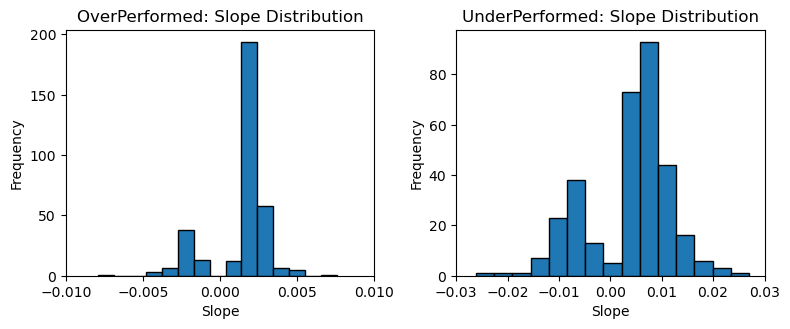

In [ ]:
# Plot histogram of slopes for high-sensitivity group
plt.figure(figsize=(8,6))
plt.subplot(2, 2, 1)  # Create the first subplot (top-left)
plt.hist(h_regression_results['slope'], bins=15, edgecolor='black')  # Add edge color for clarity
plt.xlim(-0.01, 0.01)  # Set consistent x-axis limits for comparison
plt.title("OverPerformed: Slope Distribution")  # Add a descriptive title
plt.xlabel("Slope")  # Label the x-axis
plt.ylabel("Frequency")  # Label the y-axis

# Plot histogram of slopes for low-sensitivity group
plt.subplot(2, 2, 2)  # Create the second subplot (top-right)
plt.hist(l_regression_results['slope'], bins=15, edgecolor='black')  # Add edge color for clarity
plt.xlim(-0.03, 0.03)  # Set consistent x-axis limits for comparison
plt.title("UnderPerformed: Slope Distribution")  # Add a descriptive title
plt.xlabel("Slope")  # Label the x-axis
plt.ylabel("Frequency")  # Label the y-axis

# Adjust the layout to prevent overlapping of titles, labels, and subplots
plt.tight_layout()

# Show the plots
plt.show()

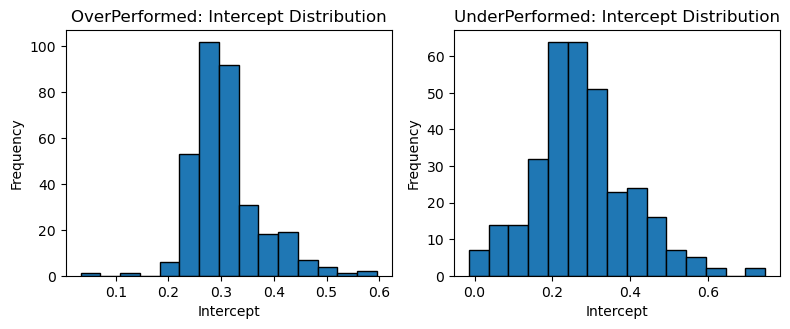

In [ ]:
# Plot histogram of intercepts for high-sensitivity group
plt.figure(figsize=(8,6))
plt.subplot(2, 2, 1)  # Create the first subplot (top-left)
plt.hist(h_regression_results['intercept'], bins=15, edgecolor='black')  # Add edge color for better clarity
plt.title("OverPerformed: Intercept Distribution")  # Add a descriptive title
plt.xlabel("Intercept")  # Label the x-axis
plt.ylabel("Frequency")  # Label the y-axis

# Plot histogram of intercepts for low-sensitivity group
plt.subplot(2, 2, 2)  # Create the second subplot (top-right)
plt.hist(l_regression_results['intercept'], bins=15, edgecolor='black')  # Add edge color for better clarity
plt.title("UnderPerformed: Intercept Distribution")  # Add a descriptive title
plt.xlabel("Intercept")  # Label the x-axis
plt.ylabel("Frequency")  # Label the y-axis

# Adjust the layout to prevent overlapping of titles, labels, and subplots
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
import pandas as pd

# Define the columns to use for character metadata
columns_to_use = [
    "Wikipedia movie ID", "Freebase movie ID", "Movie release date",
    "Character name", "Actor date of birth", "Actor gender", 
    "Actor height (in meters)", "Actor ethnicity (Freebase ID)", 
    "Actor name", "Actor age at movie release", 
    "Freebase character/actor map ID", "Freebase character ID", 
    "Freebase actor ID"
]

# Load character metadata from the TSV file with specified column names
char_metadata = pd.read_csv(
    "data/character.metadata.tsv",
    sep='\t',
    header=None,  # No header in the file; use specified column names
    names=columns_to_use  # Use the predefined column names
)

# Merge character metadata with the `higher` dataframe on common keys
higher_actor = pd.merge(
    char_metadata, higher, 
    how='inner',  # Perform an inner join to retain matching rows
    left_on=['Wikipedia movie ID', 'Freebase movie ID'],  # Keys from char_metadata
    right_on=['Wikipedia movie ID', 'Freebase movie ID']  # Keys from higher
)

# Drop unnecessary columns from the `higher_actor` dataframe
columns_to_drop = [
    'Freebase movie ID', 'Movie release date', 'Movie languages', 
    'Movie countries', 'Movie genres', 'startYear', 
    'Primary Country', 'Adjusted_Revenue', 'Log_Revenue', 
    'Movie box office revenue', 'Movie runtime', 'Movie release year', 
    'rate', 'Actor ethnicity (Freebase ID)', 'Freebase character/actor map ID', 
    'Freebase character ID', 'Freebase actor ID', 'Actor height (in meters)'
]
higher_actor = higher_actor.drop(columns=columns_to_drop)

# Remove rows with missing values in the "Actor name" column
higher_actor = higher_actor.dropna(subset=["Actor name"])

# Merge character metadata with the `lower` dataframe on common keys
lower_actor = pd.merge(
    char_metadata, lower, 
    how='inner',  # Perform an inner join to retain matching rows
    left_on=['Wikipedia movie ID', 'Freebase movie ID'],  # Keys from char_metadata
    right_on=['Wikipedia movie ID', 'Freebase movie ID']  # Keys from lower
)

# Drop unnecessary columns from the `lower_actor` dataframe
lower_actor = lower_actor.drop(columns=columns_to_drop)

# Remove rows with missing values in the "Actor name" column
lower_actor = lower_actor.dropna(subset=["Actor name"])

# Save the merged dataframes to CSV files (optional)
# higher_actor.to_csv("higher_actor_data.csv", index=False)
# lower_actor.to_csv("lower_actor_data.csv", index=False)


In [ ]:
# Calculate the number of appearances for each actor in the higher_actor dataset
higher_actor_counts = (
    higher_actor.groupby("Actor name")  # Group by "Actor name"
    .size()  # Count the occurrences for each actor
    .reset_index(name="Appearance Count")  # Reset index and name the count column
)

# Sort the actors by their appearance count in descending order
higher_actor_sorted = higher_actor_counts.sort_values(
    by="Appearance Count", ascending=False
)

# Display the top 20 actors with the highest appearance counts
print(higher_actor_sorted.head(20))


                 Actor name  Appearance Count
3271           Frank Welker                33
2806           Eddie Murphy                31
1284           Bruce Willis                28
9820              Tom Hanks                25
8858      Samuel L. Jackson                25
8557         Robin Williams                25
6738             Matt Damon                24
4709           Jim Cummings                23
5248          Julia Roberts                22
9808             Tom Cruise                21
5010          John Travolta                21
7674            Owen Wilson                21
9505     Sylvester Stallone                21
7505           Nicolas Cage                20
6884             Mel Gibson                20
7293         Morgan Freeman                20
872             Ben Stiller                19
672   Arnold Schwarzenegger                19
3396            Gary Oldman                19
1357           Cameron Diaz                19


In [ ]:
# Calculate the number of times each actor appears in the dataset
# Group the dataset by the "Actor name" column and count the number of rows for each actor
lower_actor_counts = lower_actor.groupby("Actor name").size().reset_index(name="Appearance Count")

# Sort the results by the "Appearance Count" column in descending order
lower_actor_sorted = lower_actor_counts.sort_values(by="Appearance Count", ascending=False)

# Display the top 20 actors with the highest appearance count
print(lower_actor_sorted.head(20))

              Actor name  Appearance Count
4085   Katharine Hepburn                11
6531      Robert Woolsey                10
7155       Steve Buscemi                 9
6938      Seymour Cassel                 9
4581         Lili Taylor                 8
1254    Christian Slater                 8
4257   Kiefer Sutherland                 7
2417       Gabriel Byrne                 7
6174  Rachael Leigh Cook                 7
83           Aidan Quinn                 7
193        Alfred Molina                 7
4179       Kelly Preston                 7
7793   Wheeler & Woolsey                 7
65          Adrien Brody                 7
581     Barbara Stanwyck                 7
2827         Henry Fonda                 7
682          Bette Davis                 7
5891        Parker Posey                 7
6194     Rade Serbedzija                 7
4230      Kevin Corrigan                 6


In [ ]:
Frist_20_lower_actor = lower_actor_sorted.head(20)
Frist_20_higher_actor = higher_actor_sorted.head(20)
Frist_20_lower_actor.to_csv('src/data/LowerActor.csv', index=False)
Frist_20_higher_actor.to_csv('src/data/HigherActor.csv', index=False)